In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import requests
import glob
from bs4 import BeautifulSoup
import re
import wget
import shutil
import datetime
from tqdm import tqdm_notebook
#Libs for data manip
import pandas as pd
import numpy as np
# Libs for vizu
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

!jupyter nbextension enable --py --sys-prefix ipyleaflet

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


# Première Partie : Récupération des données 

Ici je présente 2 solutions, la première consiste à créer un flder Excel_files et d'y stocker tous les fichiers de classement xlsx pour ensuite être formatés dans un dataframe.
La Seconde solution est d'aller lire directement le fichier via l'url et de le stocker dans un dataframe qui sera lui même ajouter au dataframe finale avec tous les classemenents à jour.

Pour celà je crée une fonction get_rank_list() qui va scrapper et stocker toutes les dates de classement dans une liste.
Je récupère cette liste qui me servira aussi plus tard dans l'étude de série temporelle en les convertissant au format Datetime.

In [3]:
def get_rank_list():
    """
    Function that parse the vendeeglobe site to get all date ranks and stock it into a list
    @param: None
    """
    
    list_rank_vg = list()
    r = requests.get("https://www.vendeeglobe.org/fr/classement")
    rx = re.compile('<option value="([^<]+)">')
    for match in rx.finditer(r.content.decode('utf-8')):
            list_rank_vg.append(match.group(1))
    return list_rank_vg

In [4]:
def load_xlsx():
    """
    Function that delete and recreate Excel folder and load each rank xlsx file into it
    @param: None
    """

    shutil.rmtree('Excel_files/')
    os.mkdir('Excel_files/')
    list_rank_vg = get_rank_list()
    for item_list in tqdm_notebook(list_rank_vg):
        wget.download("https://www.vendeeglobe.org/download-race-data/vendeeglobe_"+item_list+".xlsx", out="Excel_files/")

In [5]:
def df_loadwithfolder():
    """
    Function that loads all xlsx files ranking
    @param: None
    """

    # Use previous function to load all xlsx files and stock into Excel_files folder
    load_xlsx()
    df = pd.DataFrame()
    list_rank = get_rank_list()
    #get all files name in folder for each in ascending order add into big dataframe (from Exercices session 4) 
    files = glob.glob('Excel_files/*.xlsx')
    files.sort()
    for filename in tqdm_notebook(files):
        for ele in list_rank[::-1]:
            xlsx_vg = pd.read_excel(filename, 
                    skiprows=[0, 1, 3, 4, 38, 39, 40, 41],
                    names=['to delete', 'Rang', 'N° voile', 'Skipper', 'Datetime', 'Lat', 'Long', 'Cap_30m (°)' , 'Vitesse_30m (kts)', 'VMG_30m (kts)', 'Distance_30m (nm)', 'Cap_last (°)', 'Vitesse_last (kts)', 'VMG_last (kts)', 'Distance_last (nm)', 'Cap_24h (°)', 'Vitesse_24h (kts)', 'VMG_24h (kts)', 'Distance_24h (nm)', 'DTF (nm)', 'DTL (nm)'])
            # Add column with datetime corresponding to date rank from list_rank
            xlsx_vg["Datetime"] = ele
            # Convert Date column with datetime good format
            xlsx_vg["Date"] = pd.to_datetime(ele, format='%Y%m%d_%H%M%S')
            df = df.append(xlsx_vg, ignore_index=True)
    # delete 2 useless columns (because of xlsx format vendeeglobe)
    df.drop(columns=['to delete', 'Datetime'],axis=1, inplace=True)
    return df
# df = df_loadwithfolder()

In [6]:
def df_load_withoutfolder():
    """
    Function that stock each rank into dataframe and append into the big one
    @param: None
    """

    df = pd.DataFrame()
    list_rank = get_rank_list()
    if (len(list_rank) != 0):
        for ele in (list_rank[::-1]) :
            xlsx_vg = pd.read_excel("https://www.vendeeglobe.org/download-race-data/vendeeglobe_"+ele+".xlsx",
                                    sep='\t',
                                    skiprows=[0, 1, 3, 4, 38, 39, 40, 41],
                                    names=['to delete', 'Rang', 'N° voile', 'Skipper', 'Datetime', 'Lat', 'Long', 'Cap_30m (°)' , 'Vitesse_30m (kts)', 'VMG_30m (kts)', 'Distance_30m (nm)', 'Cap_last (°)', 'Vitesse_last (kts)', 'VMG_last (kts)', 'Distance_last (nm)', 'Cap_24h (°)', 'Vitesse_24h (kts)', 'VMG_24h (kts)', 'Distance_24h (nm)', 'DTF (nm)', 'DTL (nm)'])
            # Add column with datetime corresponding to date rank from list_rank
            xlsx_vg["Datetime"] = ele
            # Convert Date column with datetime good format
            xlsx_vg["Date"] = pd.to_datetime(ele, format='%Y%m%d_%H%M%S')
            df = df.append(xlsx_vg, ignore_index=True)
        # delete 2 useless columns (because of xlsx format vendeeglobe)
        df.drop(columns=['to delete', 'Datetime'],axis=1, inplace=True)
    else:
        print("Rank list non initialize. Verify url !")
    return df


In [7]:
# Functions to convert Latitude and Longitude from degree/minute/second into decimal degree
def dms2dd(degrees, minutes, seconds, direction):
    """
    Function that convert each part of lat/long
    @param: degrees / minutes / seconds / direction -> String
    """
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd

def parse_dms(dms):
    """
    Function that split lat/long into degree / minute / second stock into list
    @param: dms -> String 
    """
    parts = re.split('[°\'."]+', dms)
    dd = dms2dd(parts[0], parts[1], parts[2], parts[3])
    return dd

In [8]:
df = df_load_withoutfolder()
print(df)

     Rang    N° voile                                Skipper         Lat  \
0     NaN    \nFRA 79                  Charlie Dalin\nAPIVIA         NaN   
1     NaN     \nFRA 4          Sébastien Simon\nARKEA PAPREC         NaN   
2     NaN    \nFRA 30    Clarisse Cremer\nBanque Populaire X         NaN   
3     NaN    \nFRA 18          Louis Burton\nBureau Vallée 2         NaN   
4     NaN    \nFRA 50     Miranda Merron\nCampagne de France         NaN   
...   ...         ...                                    ...         ...   
4483   29   \nFIN 222                     Ari Huusela\nStark  18°54.56'S   
4484   30    \nJPN 11  Kojiro Shiraishi\nDMG MORI Global One  17°43.39'S   
4485   31  FR\nFRA 69             Sébastien Destremau\nMerci  17°14.07'S   
4486   32     \nFRA 8                  Jérémie Beyou\nCharal  07°08.85'S   
4487  RET     \nFRA 6      Nicolas Troussel\nCORUM L'Épargne         NaN   

            Long Cap_30m (°) Vitesse_30m (kts) VMG_30m (kts)  \
0            NaN       

In [9]:
df_initial = df

Maintenant nous allons formater le dataframe, pour celà je vais supprimer les NaN qui pour la plupart correspond aux premiers classement (où il n'y avait aucune vitesse/distance/etc... de renseigner) et aux personnes qui ont stoppé pendant un jour dû à un problème technique ou abandon.

Ensuite je vais aussi convertir les colonnes vitesse/distance/cap/vmg en supprimant aussi l'unité déjà présente dans le nom de la colonne. Je convertis aussi les latitudes et longitudes. Et je nettoie aussi les colonnes Skipper et N° de voile qui ont des formats propres au vendée globe mais qui ne sont pas très propres dans notre cas.

In [10]:
columns_float = ['Cap_30m (°)' , 'Vitesse_30m (kts)', 'VMG_30m (kts)', 'Distance_30m (nm)', 'Cap_last (°)', 'Vitesse_last (kts)', 'VMG_last (kts)', 'Distance_last (nm)', 'Cap_24h (°)', 'Vitesse_24h (kts)', 'VMG_24h (kts)', 'Distance_24h (nm)', 'DTF (nm)', 'DTL (nm)']

def clean_process_rank(df, columns_float=columns_float, columns_todelete=None):
    """
    Function that clean rank dataframe
    @param: 
    df -> Dataframe
    columns_float -> list
    columns_todelete -> list 
    """

    df.dropna(axis=0, inplace=True)
    
    if columns_todelete != None:    
        for column in columns_todelete:
            df.drop(columns=columns, axis=1, inplace=True)
    else:
        pass
    
    for cloumn in columns_float:
        df[cloumn] = df[cloumn].apply(lambda x: re.sub("[^\d\.]", "", x)).astype(float)
    df["Skipper"] = df["Skipper"].apply(lambda x: x.title())
    df["Rang"] = df["Rang"].astype('float')
    df["Lat"] = df["Lat"].apply(lambda x: parse_dms(x))
    df["Long"] = df["Long"].apply(lambda x: parse_dms(x))
    df['Skipper'] = df['Skipper'].apply(lambda x: x.split('\n')[0])
    df['N° voile'] = df['N° voile'].apply(lambda x: x.split('\n')[1])

    return df

In [11]:
df_cleaned = clean_process_rank(df)
df_cleaned.head(10)

,Rang,N° voile,Skipper,Lat,Long,Cap_30m (°),Vitesse_30m (kts),VMG_30m (kts),Distance_30m (nm),Cap_last (°),Vitesse_last (kts),VMG_last (kts),Distance_last (nm),Cap_24h (°),Vitesse_24h (kts),VMG_24h (kts),Distance_24h (nm),DTF (nm),DTL (nm),Date
33,1.0,FRA 18,Louis Burton,46.412778,-1.846667,241.0,17.7,17.5,0.3,357.0,0.0,0.0,2788.0,201.0,0.3,0.3,6.1,24293.9,0.0,2020-11-08 14:00:00
34,2.0,MON 10,Boris Herrmann,46.409444,-1.839444,241.0,11.1,10.9,0.4,357.0,0.0,0.0,2787.9,196.0,0.3,0.2,6.0,24294.2,0.4,2020-11-08 14:00:00
35,3.0,FRA 8,Jérémie Beyou,46.425278,-1.844167,244.0,15.5,15.5,0.5,357.0,0.0,0.0,2788.5,199.0,0.2,0.2,5.5,24294.3,0.5,2020-11-08 14:00:00
36,4.0,FRA 59,Thomas Ruyant,46.419722,-1.835556,244.0,13.2,13.1,0.7,357.0,0.0,0.0,2788.3,196.0,0.2,0.2,5.6,24294.5,0.6,2020-11-08 14:00:00
37,5.0,FRA 53,Maxime Sorel,46.416389,-1.832222,246.0,10.9,10.9,0.2,357.0,0.0,0.0,2788.1,195.0,0.8,0.7,5.8,24294.5,0.6,2020-11-08 14:00:00
38,6.0,FRA 56,Fabrice Amedeo,46.421944,-1.840833,238.0,16.9,16.9,0.6,357.0,0.0,0.0,2788.7,200.0,0.2,0.2,5.3,24294.5,0.7,2020-11-08 14:00:00
39,7.0,FRA 01,Jean Le Cam,46.425000,-1.830278,247.0,10.7,10.7,0.2,357.0,0.0,0.0,2788.4,196.0,0.2,0.2,5.5,24294.7,0.8,2020-11-08 14:00:00
40,8.0,GBR 99,Alex Thomson,46.422500,-1.829167,238.0,13.8,13.7,1.1,357.0,0.0,0.0,2788.7,196.0,0.2,0.2,5.2,24294.8,1.0,2020-11-08 14:00:00
41,9.0,FRA 69,Sébastien Destremau,46.417778,-1.825556,245.0,9.6,9.6,0.3,357.0,0.0,0.0,2788.6,195.0,0.2,0.2,5.3,24294.8,1.0,2020-11-08 14:00:00
42,10.0,GBR 777,Pip Hare,46.422778,-1.826667,245.0,12.7,12.7,0.4,357.0,0.0,0.0,2788.8,196.0,0.2,0.2,5.1,24294.9,1.0,2020-11-08 14:00:00


Voilà l'extrait du dataframe des classements nettoyé, maintenant nous allons récupérer les données de chaque bateaux pour pouvoir ensuite réaliser nos études.

In [12]:
# Name of each column corresponding to the caracteristic tag from web page
_columns = ['Skipper', 'Numéro de voile', 'Anciens noms du bateau', 'Architecte',
    'Chantier', 'Date de lancement', 'Longueur', 'Largeur', "Tirant d'eau",
    'Déplacement (poids)', 'Nombre de dérives', 'Hauteur mât',
    'Voile quille', 'Surface de voiles au près',
    'Surface de voiles au portant']

def get_boats(columns_boat = _columns): 
    """
    Function that return boat infos dataframe
    @param: 
    _columns -> list
    """
    soup = BeautifulSoup(requests.get("https://www.vendeeglobe.org/fr/glossaire").content)
    skipper_names = [skipper_name.text for skipper_name in soup.find_all('span', {'class': 'boats-list__skipper-name'})]
    boats = pd.DataFrame(columns=columns_boat)
    # For each boat infos corresponding to the skipper name from previous list map all info into another list and stock all in number of caracteristic * 1 so convert into serie and stock it into final dataframe
    for i, boat in enumerate(soup.find_all('div', {'class': 'boats-list__popup-infos'})):
        boat_infos = np.array([['Skipper', skipper_names[i]]] + [list(map(str.strip, elem.text.split(':', 1))) for elem in boat.find_all('li')])
        boats = boats.append(pd.Series(boat_infos[:, 1], index=boat_infos[:, 0]), ignore_index=True)
    return boats, skipper_names
df_boats, skipper_names = get_boats()
print(df_boats.head(5))

            Skipper Numéro de voile  \
0    Fabrice AMEDEO          FRA 56   
1  Romain ATTANASIO          FRA 49   
2    Alexia BARRIER           FRA72   
3  Yannick BESTAVEN              17   
4     Jérémie BEYOU              08   

                              Anciens noms du bateau         Architecte  \
0                     No Way Back, Vento di Sardegna       VPLP/Verdier   
1           Gitana Eighty, Synerciel, Newrest-Matmut  Bruce Farr Design   
2  Famille Mary-Etamine du Lys, Initiatives Coeur...       Marc Lombard   
3                      Safran 2 - Des Voiles et Vous     Verdier - VPLP   
4                                                NaN               VPLP   

                                   Chantier Date de lancement Longueur  \
0                            Persico Marine      01 Août 2015  18,28 m   
1  Southern Ocean Marine (Nouvelle Zélande)      08 Mars 2007   18,28m   
2                                MAG France      01 Mars 1998   18,28m   
3                 

Ici on s'aperçoit que certaines colonnes sont très redondantes et parfois une unique valeur est présente pour chacun des skippers. Par exemple le Tirant d'eau a la même valeur 4,5 m de même pour la longueur. 
Ainsi je vais regarder le nombre de valeur pour les colonnes susceptibles d'être supprimées et afficher un histograme de distribution des valeurs possibles.

Famille Mary-Etamine du Lys, Initiatives Coeur, Le Pingouin                                       1
Spirit of Yukoh, Neutrogena, Hugo Boss, Estrella Damm, Veolia Environnement, BT                   1
Ecover3, Président, Gamesa, Kilcullen Voyager-Team Ireland                                        1
Maître CoQ - Banque Populaire VII- Foncia II                                                      1
Saint-Michel - Virbac                                                                             1
Paprec-Virbac2, Estrella Damm, We are Water, La Mie Câline                                        1
Le Souffle du Nord, Groupe Bel                                                                    1
Safran 2 - Des Voiles et Vous                                                                     1
Aviva, GAES Centros Auditivos                                                                     1
Edmond de Rothschild, Malizia - Yacht Club de Monaco                                              1


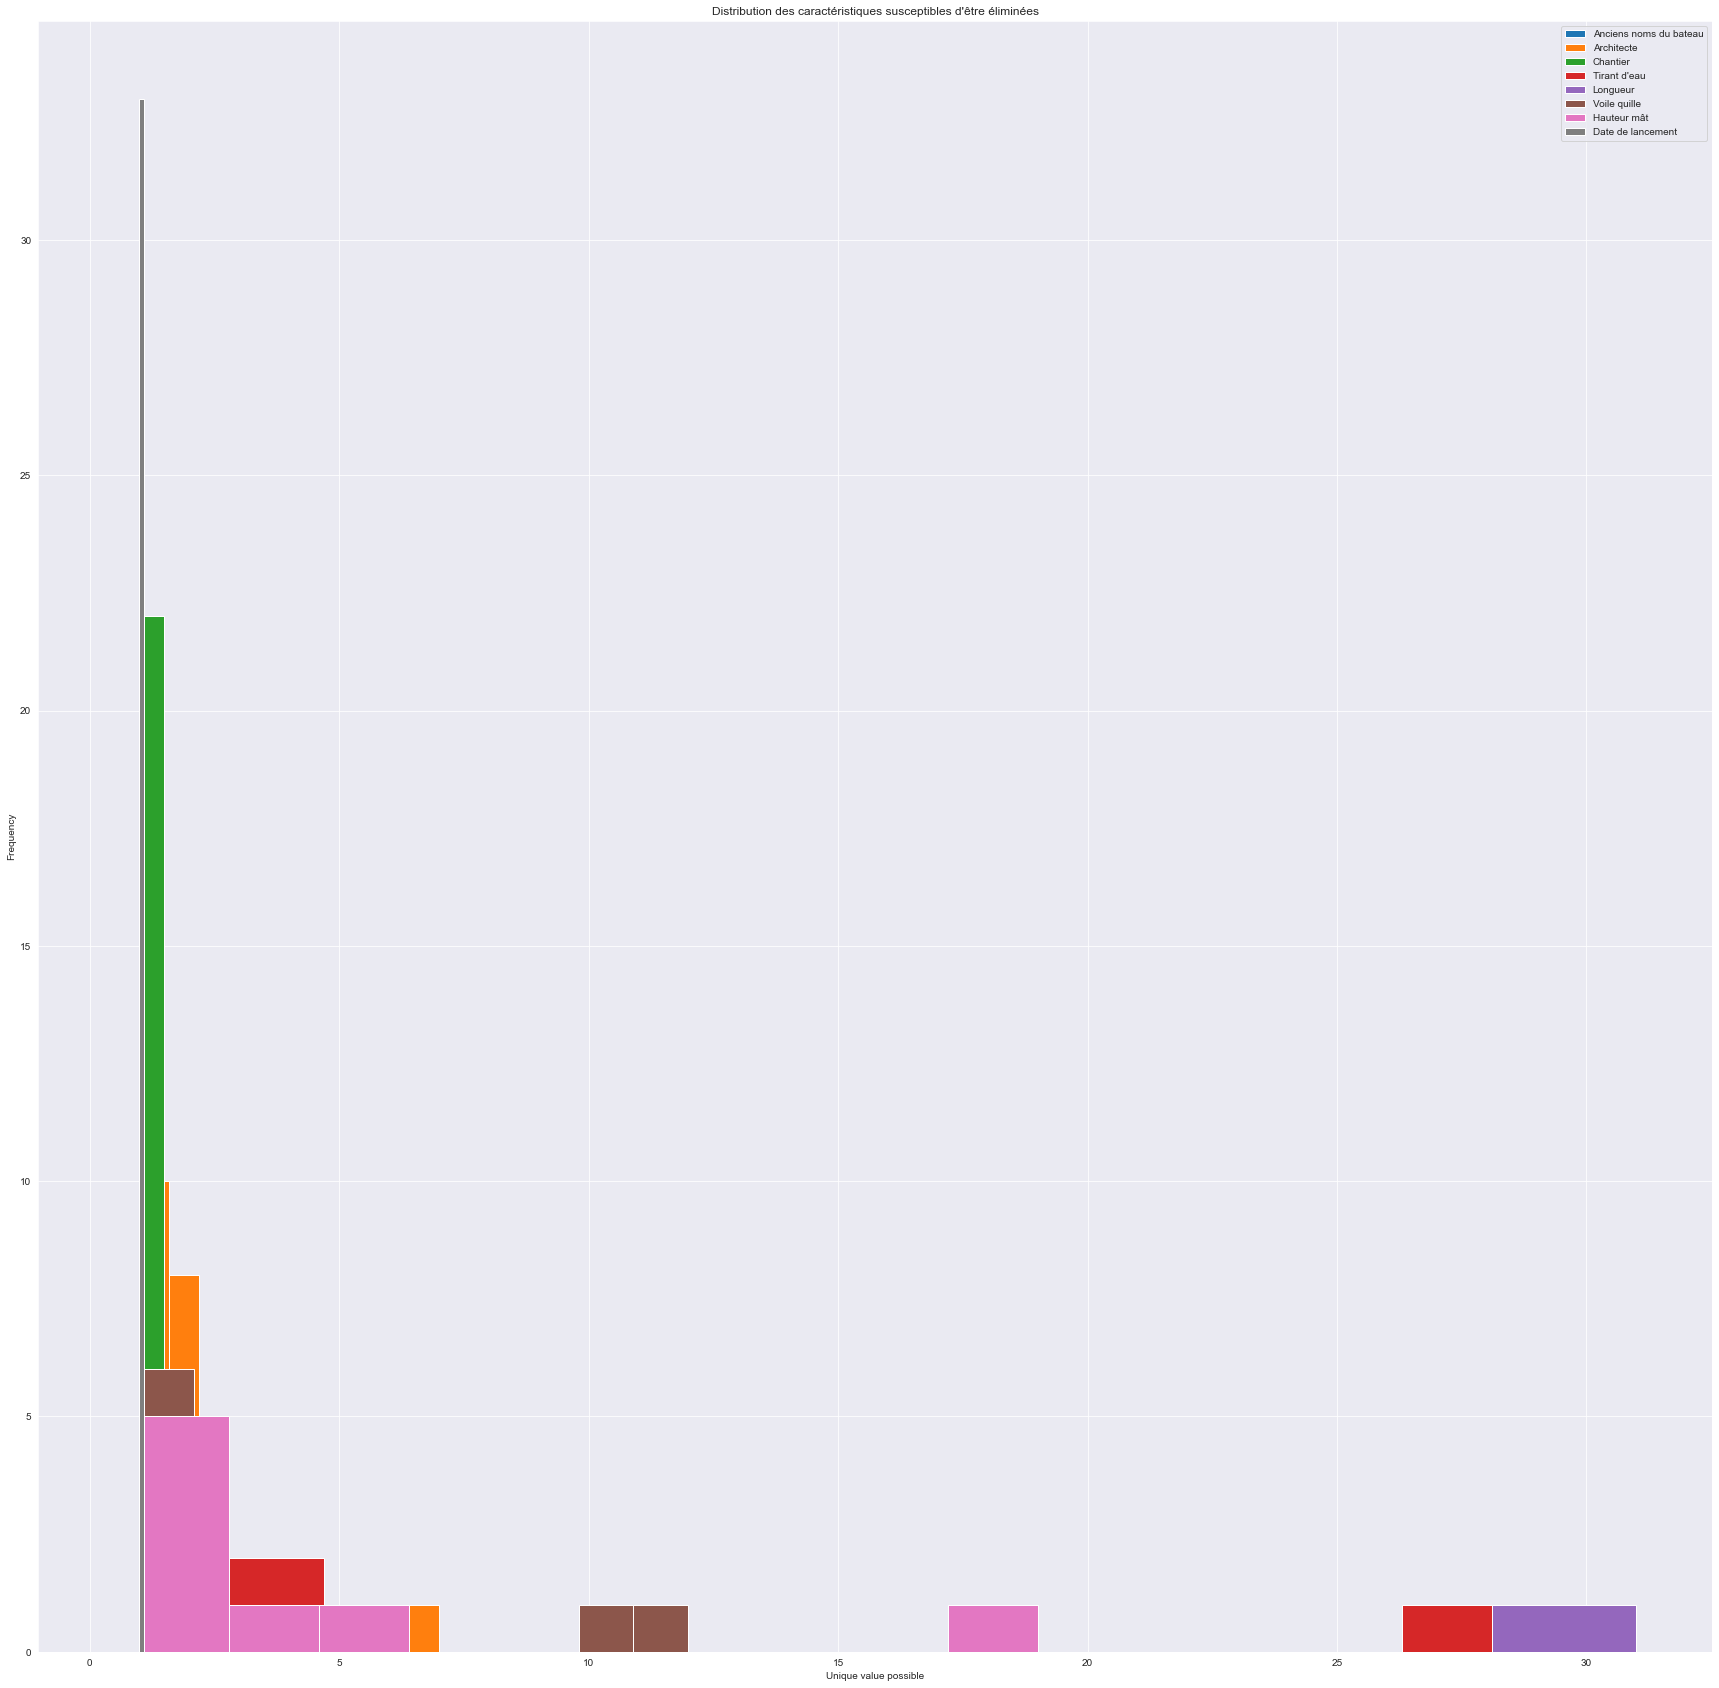

In [13]:
columns_todelete = ['Anciens noms du bateau', 'Architecte',
       'Chantier', "Tirant d'eau", 'Longueur', 'Voile quille', 'Hauteur mât', 'Date de lancement'] 
df_delete = pd.DataFrame(columns=columns_todelete)

for ele in columns_todelete :
    print(df_boats[ele].value_counts())
    df_delete.append(df_boats[ele].value_counts())
    df_boats[ele].value_counts().plot.hist(figsize = (30,30))
    plt.legend()
    plt.title("Distribution des caractéristiques susceptibles d'être éliminées")
    plt.xlabel("Unique value possible")
    print("---------------------------------------------------------------------------------------------------")


Ici on voit bien la confirmation que certaines variables sont inutiles comme la longueur, le tirant d'eau. Je supprime aussi les noms de chantiers, l'architecte, l'ancien nom de bateau, la date de lancement car ce ne sont pas des caractéristiques propres à la configuration du bateau.

In [14]:
def clean_process_boats(df, columns_todelete):
    """
    Function that return boat infos dataframe
    @param: 
    df -> Dataframe
    columns_todelete -> list
    """
    df.drop(columns=columns_todelete, axis=1, inplace=True)
    df.replace(['nc', 'NC'], '0', inplace=True)
    df['Largeur'] = df['Largeur'].apply(lambda x: re.sub("[^\d\,]", "", x)).replace({',': '.'}, regex=True).astype(float)
    df['Déplacement (poids)'] = df['Déplacement (poids)'].apply(lambda x: x.split('t')[0]).replace({',': '.'}, regex=True).astype(float)
    df['Surface de voiles au près'] = df['Surface de voiles au près'].apply(lambda x: x.split(' ')[0]).astype(float)
    df['Surface de voiles au portant'] = df['Surface de voiles au portant'].apply(lambda x: x.split(' ')[0]).astype(float)
    df['Nombre de dérives'] = df['Nombre de dérives'].apply(lambda x: True if x == "foils" else False).astype(bool)
    df.rename(columns={"Largeur": "Largeur (m)", "Déplacement (poids)": "Poids (t)", "Nombre de dérives": "Foils", "Surface de voiles au près": "Surface de voiles au près (m2)", "Surface de voiles au portant": "Surface de voiles au portant (m2)"}, inplace=True)
    # Add Gender following the first extract of first test (i did it because we have only 32 skippers otherwise i will need to find other method)
    df["Gender"] = ["M", "M", "F", "M", "M", "M", "M", "M", "M", "F", "M", "F", "M", "M", "M", "M", "F", "M", "M", "F", "M", "M", "F", "M", "M", "M", "M", "M", "M", "M", "M", "M", "M"]
    df["Skipper"] = df["Skipper"].apply(lambda x: x.title())

    return df

In [15]:
df_boats = clean_process_boats(df_boats, columns_todelete)
# Reformat Sam Davies skipper name for futur merge & groupby operations
df_boats['Skipper'] = df_boats['Skipper'].apply(lambda x: "Samantha Davies" if x == 'Sam Davies' else x)
df_boats.set_index('Skipper', inplace=True)
df_boats.sort_index(ascending=True, inplace=True)
df_boats

,Numéro de voile,Largeur (m),Poids (t),Foils,Surface de voiles au près (m2),Surface de voiles au portant (m2),Gender
Skipper,,,,,,,
Alan Roura,SUI07,5.90,0.0,True,290.0,580.0,M
Alex Thomson,GBR 99,5.40,7.7,True,330.0,630.0,M
Alexia Barrier,FRA72,5.54,9.0,False,260.0,580.0,F
Ari Huusela,FIN222,5.80,8.5,False,270.0,580.0,M
Armel Tripon,2,5.50,7.8,True,270.0,535.0,M
Arnaud Boissières,FRA 14,5.65,7.9,True,300.0,610.0,M
Benjamin Dutreux,FRA09,5.85,8.0,False,300.0,700.0,M
Boris Herrmann,16,5.70,7.6,True,290.0,490.0,M
Charlie Dalin,FRA 79,5.85,8.0,True,350.0,560.0,M


Maintenant nous avons 6 variables caractéristiques du bateau que nous allons examiner dans la seconde partie.
Passons à la seconde partie que je diviserais en 2 :

    - une étude de série tmeporelle qui consistera à visualiser l'évolution de la VMG (vitesse plus pertinente que la vitesse classique) puis je vais tenter une prédiction sur quelques jours. Ceci en optimisant un algorithme de modélisation statistique des séries temporelles (SARIMA)
    
    - une étude de toutes les caractéristiques en utilisant des régressions linéaires ainsi qu'un algorithme ensembliste de machine learning : le random forest

# Deuxième Partie : Modélisation

Je vais commencer par regrouper toutes mes caractéristiques et pour les vitesse/distance/cap je vais prendre la valeur médiane pour être moins sensible aux outliers (ce qui peut être fréquent avec ce genre de course où des skippers ont de fortes variations de vitesse selon les conditions météorologiques)

In [16]:
tab = df_cleaned.groupby("Skipper").median()
tab.sort_index(ascending=True, inplace=True)
tab

,Rang,Lat,Long,Cap_30m (°),Vitesse_30m (kts),VMG_30m (kts),Distance_30m (nm),Cap_last (°),Vitesse_last (kts),VMG_last (kts),Distance_last (nm),Cap_24h (°),Vitesse_24h (kts),VMG_24h (kts),Distance_24h (nm),DTF (nm),DTL (nm)
Skipper,,,,,,,,,,,,,,,,,
Alan Roura,18.0,4.788611,-27.641667,184.0,12.50,11.00,6.20,184.0,12.50,10.7,45.60,186.0,11.9,10.5,285.70,21594.10,646.30
Alex Thomson,4.0,-6.866389,-26.394167,184.0,14.80,12.10,7.40,188.0,14.60,12.6,52.90,183.0,13.2,12.1,316.90,20976.10,25.40
Alexia Barrier,27.0,21.140278,-26.069167,198.0,10.10,8.70,5.00,198.0,10.00,8.5,36.30,198.0,8.6,7.4,206.00,22549.60,1597.00
Ari Huusela,27.0,20.750833,-25.205000,198.0,10.30,8.30,5.10,199.0,10.30,7.8,33.80,199.0,8.3,7.5,199.60,22515.70,1571.80
Armel Tripon,24.0,19.752222,-27.476389,191.0,12.50,8.90,6.20,193.0,12.10,8.8,43.80,193.0,11.0,8.3,264.40,22480.80,1519.00
Arnaud Boissieres,22.0,12.266944,-28.630417,190.0,11.30,8.80,5.65,191.0,11.25,9.0,40.80,190.0,10.6,8.5,254.95,22077.70,1177.85
Benjamin Dutreux,11.0,-0.873889,-26.932778,180.0,13.80,12.70,6.90,182.0,13.90,12.6,46.90,185.0,13.1,12.6,313.20,21277.90,300.20
Boris Herrmann,7.0,-1.950000,-23.868056,181.0,15.60,14.10,7.80,182.0,15.50,14.2,51.40,184.0,13.1,12.4,314.20,21224.60,289.20
Charlie Dalin,3.0,-6.089167,-22.164028,172.5,16.95,13.95,8.45,170.5,15.55,13.3,56.45,174.0,13.9,12.5,333.50,21017.20,27.25


### Etude de la VMG en série temporelle et prédiction

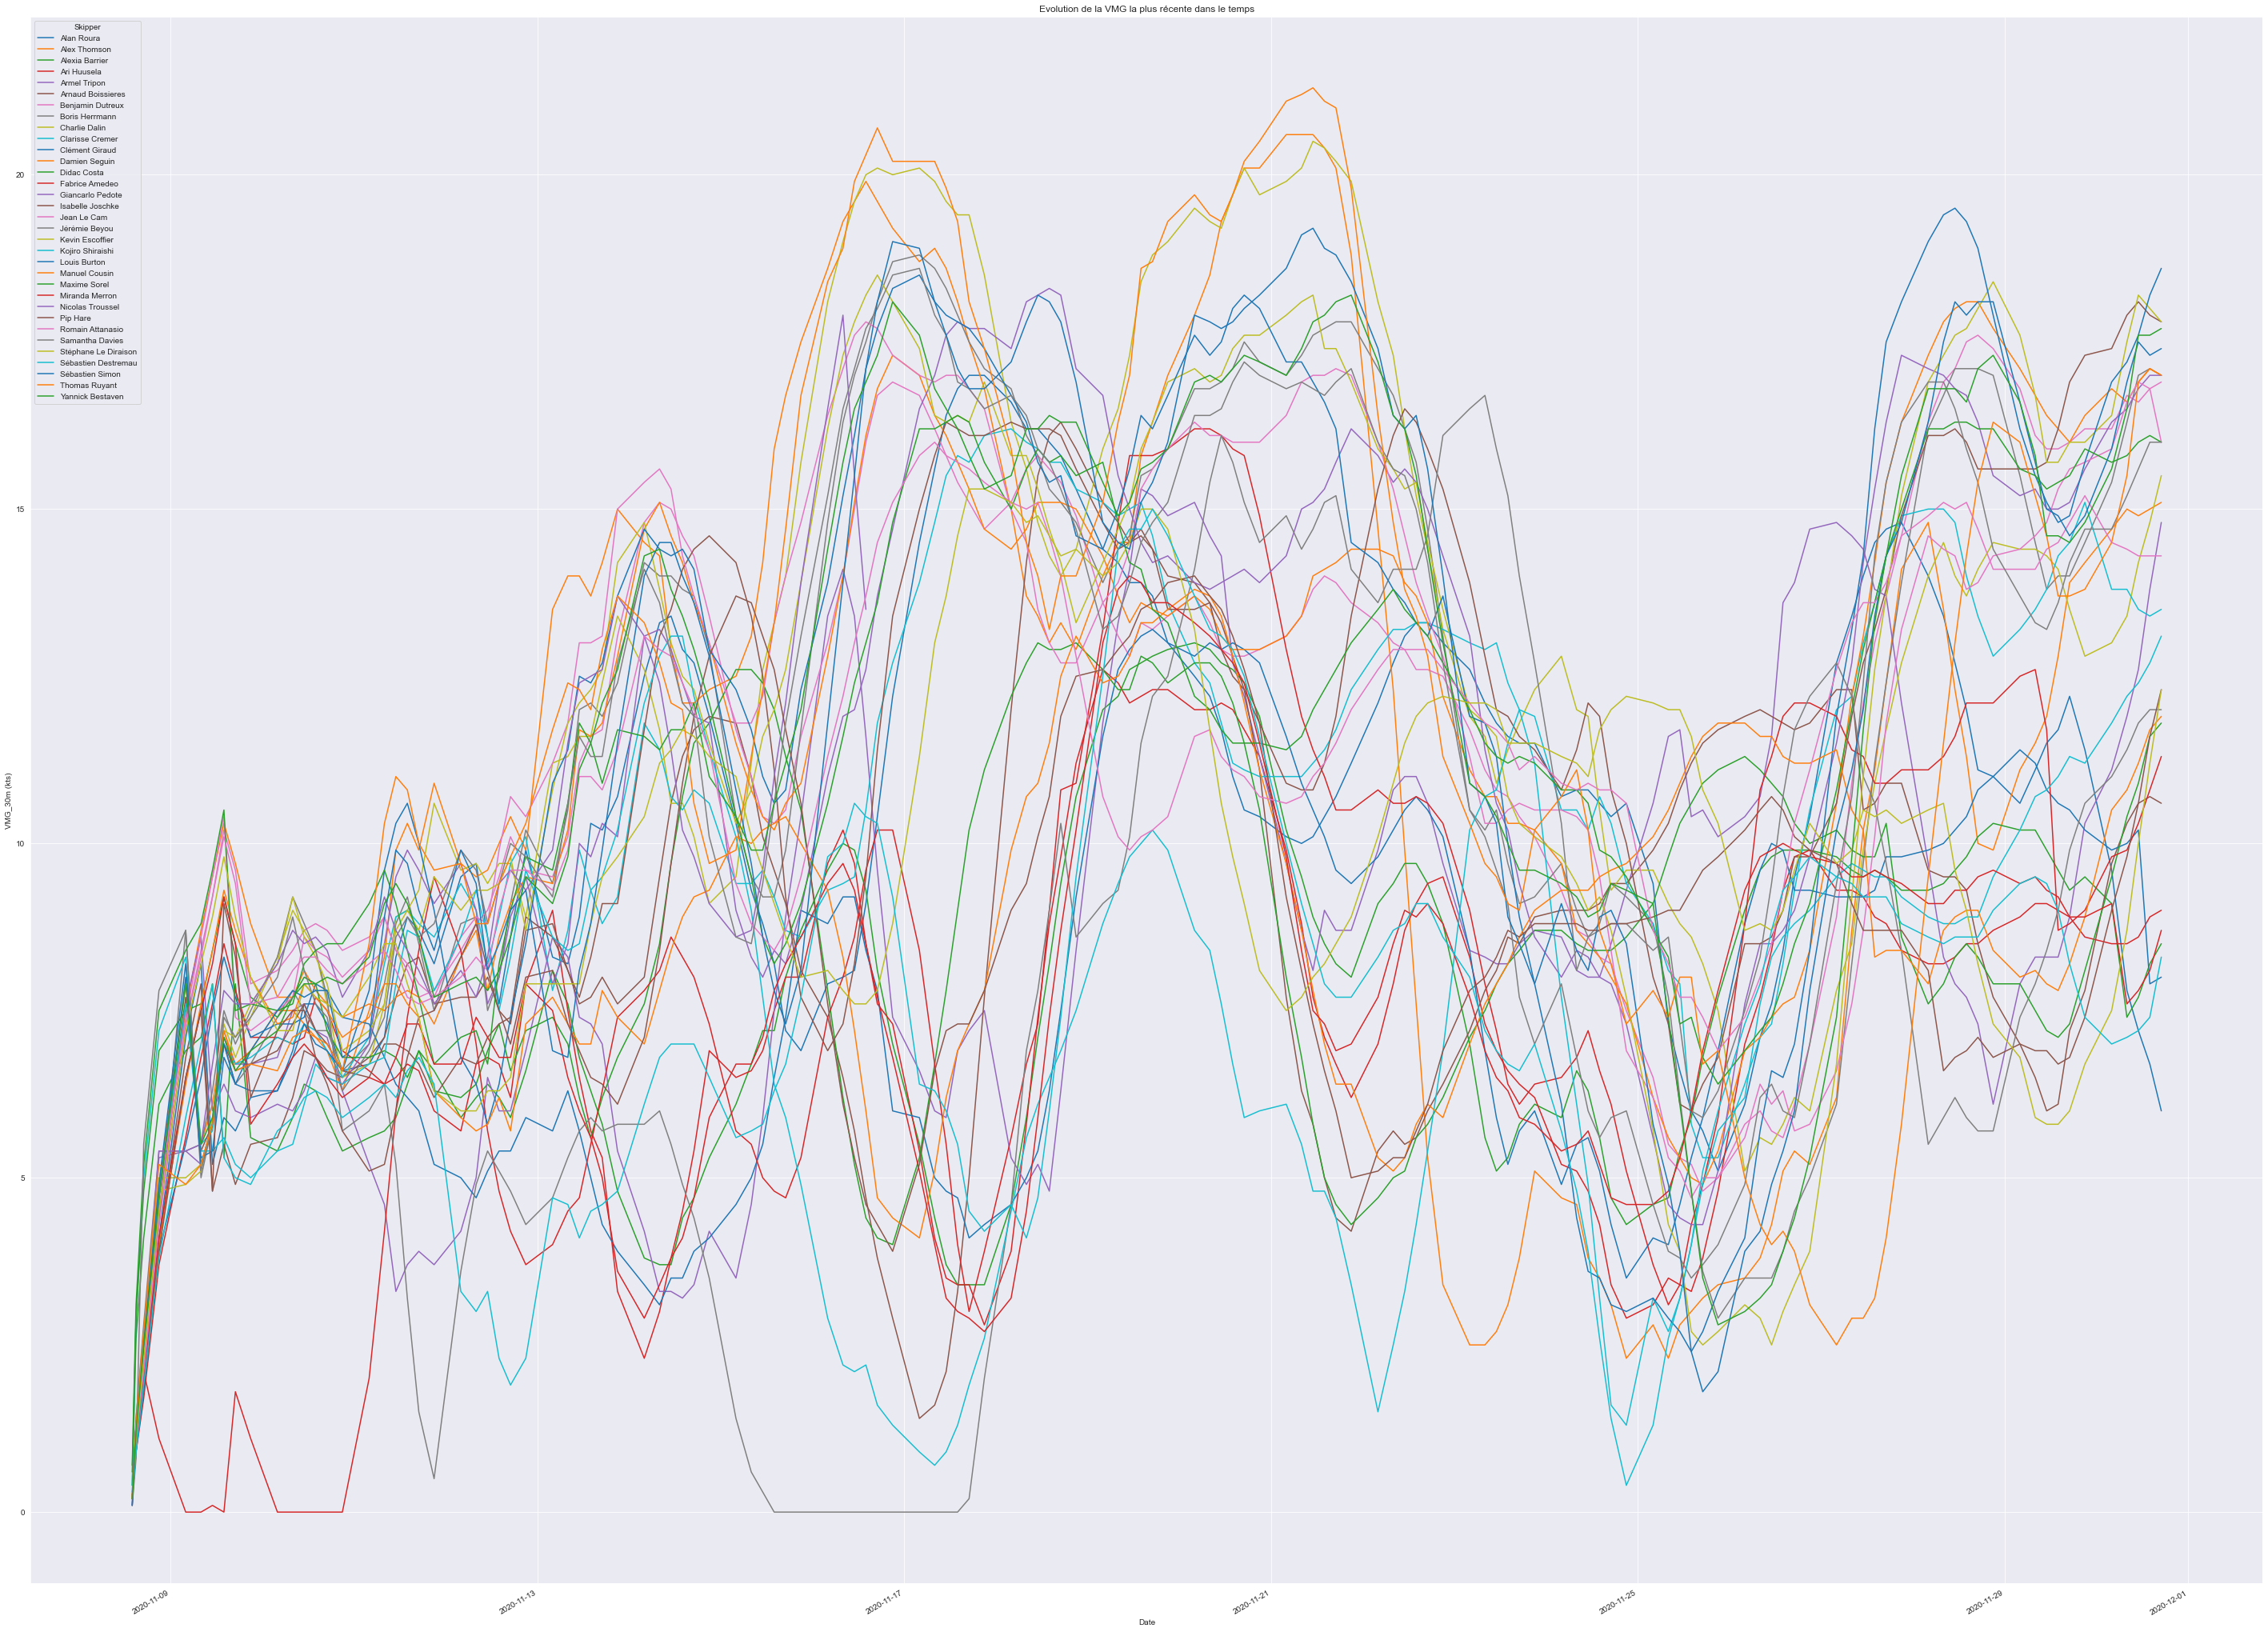

In [17]:
# Plot VMG per day TimeSeries by skippers
df_cleaned.pivot_table(index='Date', columns='Skipper', values='VMG_24h (kts)').plot(kind='line', figsize=(50, 40), title='Evolution de la VMG la plus récente dans le temps')
plt.ylabel('VMG_30m (kts)');

On remarque d'abord que l'évolution de la VMG (vitesse) est assez similaire entre skippers. 
Par exemple aux alentours du 25/11/2020, tous les skipeprs subissent une grosse perte de vitesse et juste après une forte remontée. On a aussi les même groupe de couleurs qui suivent les même style de variation. Je pourrais par exemple m'amuser à essayer d'appliquer un algorithme de clustering pour identifier des groupes de skippers qui seraient souvent dans les même rang des classements. Mais je vais plutôt essayer de prédire la VMG pour un skipper.

In [18]:
df_ts = df_cleaned.pivot_table(index='Date', columns='Skipper', values='VMG_24h (kts)')
print(df_ts)

Skipper              Alan Roura  Alex Thomson  Alexia Barrier  Ari Huusela  \
Date                                                                         
2020-11-08 14:00:00         0.1           0.2             0.4          0.2   
2020-11-08 15:00:00         1.0           1.3             2.6          0.9   
2020-11-08 17:00:00         2.1           2.7             4.1          1.7   
2020-11-08 21:00:00         4.1           4.9             6.1          3.7   
2020-11-09 04:00:00         7.1           7.9             6.9          5.6   
...                         ...           ...             ...          ...   
2020-11-30 04:00:00         9.6          14.7             9.1          8.5   
2020-11-30 08:00:00         7.8          15.0             7.4          8.5   
2020-11-30 11:00:00         7.2          14.9             7.7          8.6   
2020-11-30 14:00:00         6.7          15.0             8.2          8.9   
2020-11-30 17:00:00         6.0          15.1             8.5   

Passons maintenant à la modélisation statistique de la VMG pour un skipper choisi.

Pour ceci il faut savoir que pour étudier une série temporelle (ts), je dois tester d'abord la stationnarité de la ts. J'utilise le test de Dickey-Fuller selon la p-value qui me permettra ensuite de paramétrer mon modèle.

Je choisis d'utiliser le modèle Sarima qui se compose :

 - d'une partie AR (Auto Régressive) qui ajoute un "lag" consistant à prendre en compte les observations passées linéairement
 - d'une partie MA (Mobile Average) qui ajoute une moyenne mobile
 - d'une partie I (intégration) qui différencie selon la tendance ou moyenne la ts afin de la rendre stationnaire 
 - d'une partie S (saisonnalité) qui prend en compte des phénomènes périodiques et comme la course se situe à travers différents océans sous différent(e)s climats/saisons, peut être est-ce une bonne idée de la modéliser avec.


Je vais donc créer une fonction best_sarima qui va chercher à optimiser mon modèle avec une combinaison des paramètres.
J'utilise product pour créer ma liste de paramètres. Je stocke mes résultats dans un dataframe que j'affiche, ensuite je récupère les meilleurs selon un critère d'information spécifique (AIC) que je renvoie.


In [19]:
def best_sarima(ts, saison):
    results = []
    p = range(0, 2, 1)
    d = 1
    q = range(0, 2, 1)
    P = range(0, 2, 1)
    D = 1
    Q = range(0, 2, 1)

    parameters = product(p, q, P, Q)
    parameters_list = list(parameters)
    print(len(parameters_list))

    for param in tqdm_notebook(parameters_list):
        model = SARIMAX(ts, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], saison)).fit(disp=-1)   
        aic = model.aic
        results.append([param, aic])
            
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    print("---------------------------------------------------------")
    print("Results of Sarima optimization")
    print(result_df)
    print("---------------------------------------------------------")

    best_param = result_df.iloc[result_df["AIC"].idxmin(), 0]
    order = (best_param[0], d, best_param[1])
    seasonal_order = (best_param[2], D ,best_param[3], saison)

    return order, seasonal_order
    

Ici je créée la fonction qui va étudier et prédite la VMG pour un skipper donné.
Pour celà je prend la ts, le numéro du skipper selon le précédent dataframe puis je vais utiliser le test de Dickey-Fuller pour vérifier la stationnarité, ensuite j'affiche le corrélogramme pour se rendre compte de lag dans la série (c'est-à-dire de l'autocorrélation).

Ensuite j'optimise les paramètres du modèle, je fit avec la ts du skipper sélectionné et maintenant je vais prédire sur le nombre de jours souhaités (n_steps). Je prédit par jour puisque je me base sur la VMG des 24h (donc /jour). J'utilise la fonction plot_diagnostics du modèle pour afficher le qq-plot, le corrélogramme, la distribution, ainsi que le résidu. (Ceux sont les graphes utilisés en analyse de série temporelle)

Pour finir je passe à la visualisation avec la ts du skipper et la prédiction avec intervale de confiance à 90%.

---------------------------------------------------------
ADF Statistic: -1.8729941268856498
p-value: 0.34487019963332666
La TS de la VMG est stationnaire
---------------------------------------------------------




Display of Partial and Auto Correlation TimeSeries 
We can see if the timeserie have peak lag thus suggesting AR = AutoRegressive problem.


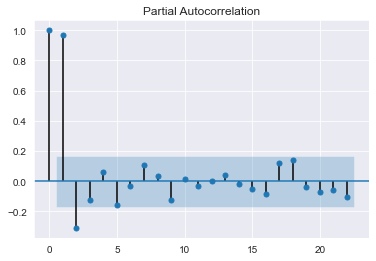

16



---------------------------------------------------------
Results of Sarima optimization
     (p,q)x(P,Q)         AIC
0   (1, 0, 0, 1)  320.079562
1   (1, 0, 1, 1)  320.460750
2   (1, 1, 0, 1)  334.914514
3   (1, 1, 1, 0)  335.107308
4   (1, 1, 0, 0)  335.572140
5   (1, 1, 1, 1)  335.763167
6   (0, 1, 1, 1)  336.704724
7   (0, 1, 0, 1)  340.771173
8   (0, 1, 0, 0)  342.957840
9   (0, 1, 1, 0)  344.932331
10  (1, 0, 1, 0)  352.942465
11  (0, 0, 1, 1)  355.295114
12  (0, 0, 0, 1)  376.123924
13  (1, 0, 0, 0)  377.021706
14  (0, 0, 1, 0)  379.619953
15  (0, 0, 0, 0)  388.615873
---------------------------------------------------------




                                      SARIMAX Results                                      
Dep. Variable:                       Thomas Ruyant   No. Observations:                  135
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 2)   Log Likelihood                -157.040
Date:                             Mon, 30 Nov 2020   AIC                       

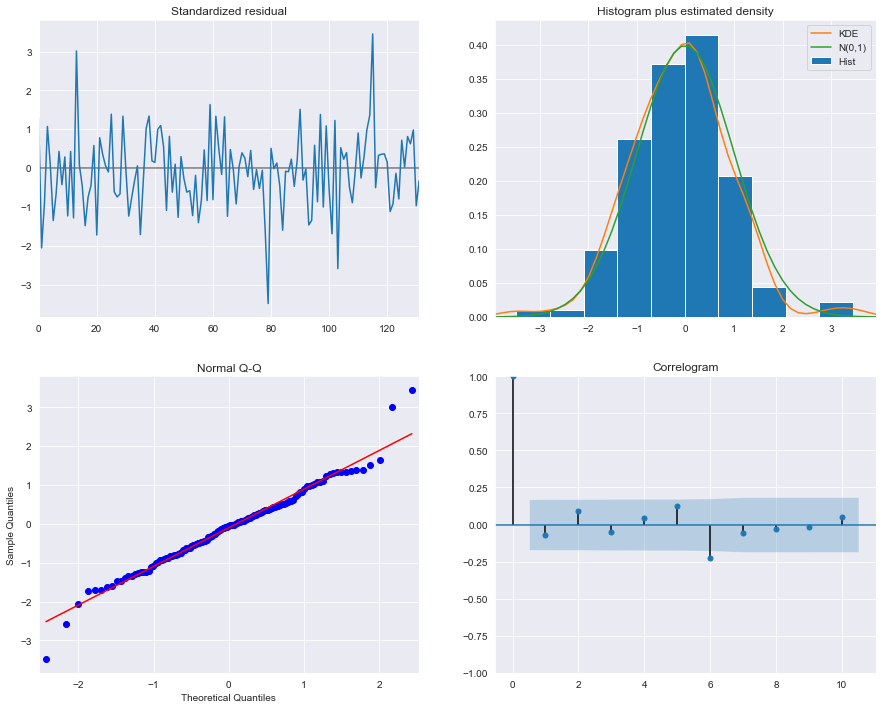






---------------------------------------------------------
ADF Statistic: -2.210269865258363
p-value: 0.20253922554668574
La TS de la VMG est stationnaire
---------------------------------------------------------




Display of Partial and Auto Correlation TimeSeries 
We can see if the timeserie have peak lag thus suggesting AR = AutoRegressive problem.


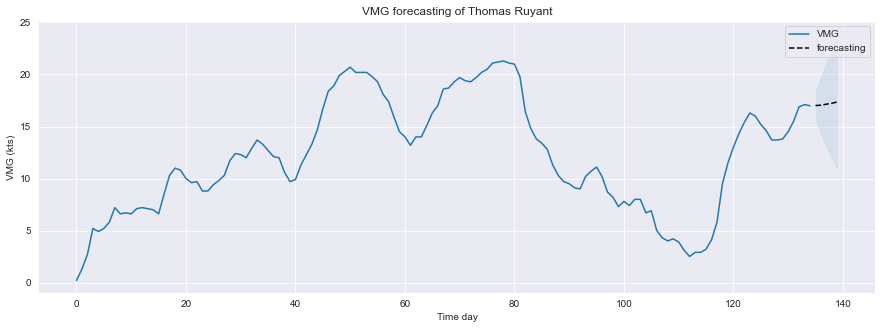

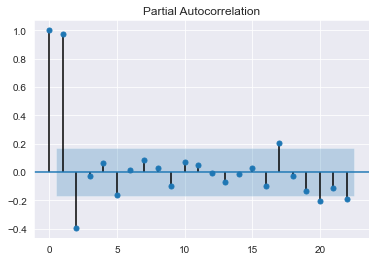

16



---------------------------------------------------------
Results of Sarima optimization
     (p,q)x(P,Q)         AIC
0   (1, 0, 0, 1)  341.983665
1   (1, 0, 1, 1)  343.845736
2   (1, 1, 0, 1)  343.867893
3   (0, 1, 1, 1)  343.952119
4   (1, 1, 1, 1)  345.855055
5   (0, 1, 0, 1)  350.082147
6   (1, 1, 1, 0)  360.042196
7   (1, 1, 0, 0)  367.863987
8   (0, 1, 1, 0)  367.986917
9   (0, 1, 0, 0)  372.051527
10  (0, 0, 1, 1)  375.797558
11  (1, 0, 1, 0)  381.746957
12  (0, 0, 0, 1)  382.568755
13  (0, 0, 1, 0)  404.753104
14  (1, 0, 0, 0)  418.906663
15  (0, 0, 0, 0)  426.045557
---------------------------------------------------------




                                      SARIMAX Results                                      
Dep. Variable:                       Jérémie Beyou   No. Observations:                  135
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 2)   Log Likelihood                -167.992
Date:                             Mon, 30 Nov 2020   AIC                       

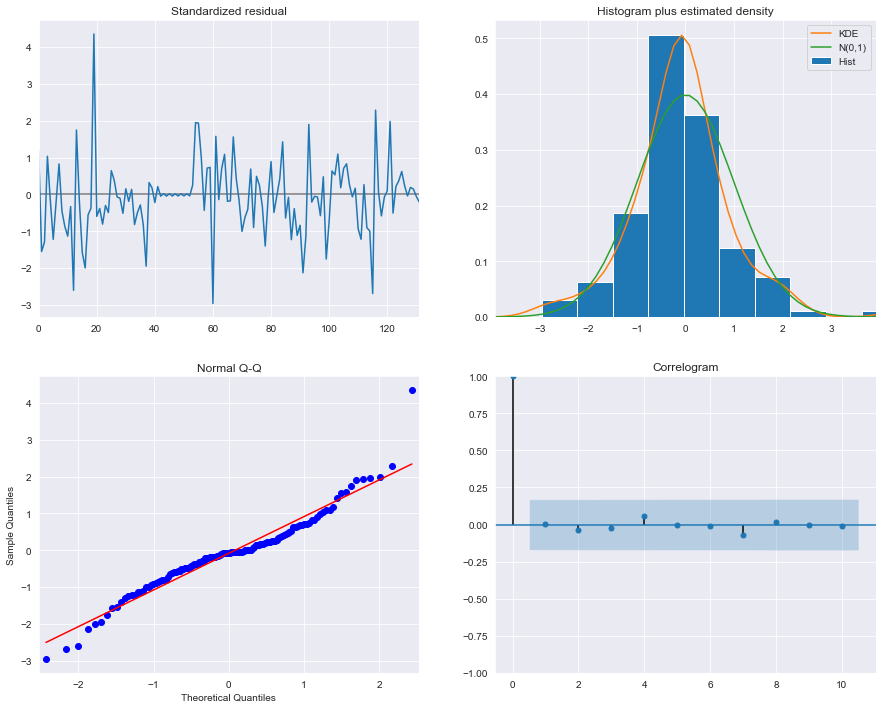

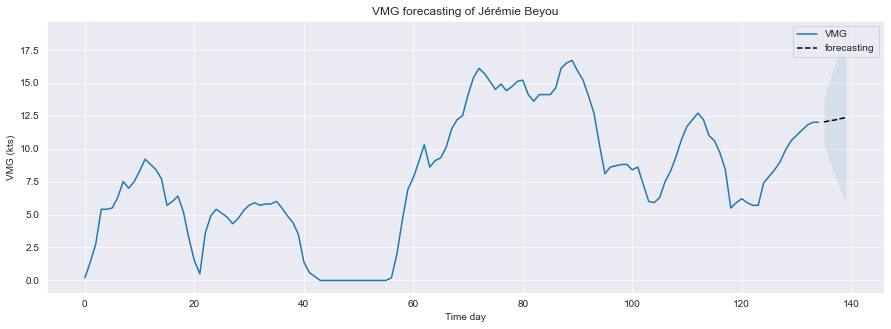

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

def mySarima(df_ts, num_skipper, n_steps=4, saison=2):
    # get the ts corresponding to the skipper and eventually fill NaN value with median to avoid outliers sensibility
    ts_skipper = pd.Series(df_ts.iloc[:, num_skipper])
    ts_skipper = ts_skipper.fillna(ts_skipper.median())

    print("---------------------------------------------------------")
    ad_fuller_result = adfuller(ts_skipper.values)
    print('ADF Statistic: {}'.format(ad_fuller_result[0]))
    print('p-value: {}'.format(ad_fuller_result[1]))
    if ad_fuller_result[1] < 1:
        print('La TS de la VMG est stationnaire')
    else:
        print('La TS de la VMG n\'est pas stationnaire')
    print("---------------------------------------------------------")
    print("\n\n\n")
    print("Display of Partial and Auto Correlation TimeSeries \nWe can see if the timeserie have peak lag thus suggesting AR = AutoRegressive problem.")
    plot_pacf(ts_skipper);
    plt.show()

    order, seasonal_order = best_sarima(ts_skipper, saison)
    best_model = SARIMAX(ts_skipper, order=order, seasonal_order=seasonal_order).fit(dis=-1)
    print("\n\n\n")
    print(best_model.summary())
    best_model.plot_diagnostics(figsize=(15,12));
    plt.show()

    ts = pd.Series(ts_skipper.values)

    forecast = best_model.get_forecast(steps=n_steps).summary_frame()

    fig, ax = plt.subplots(figsize=(15, 5))
    ts.plot(ax=ax, label='VMG')
    forecast['mean'].plot(style='k--', label='forecasting')
    ax.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], alpha=0.1);
    plt.title("VMG forecasting of {}".format(ts_skipper.name))
    plt.xlabel("Time day")
    plt.ylabel('VMG (kts)')
    plt.legend()

    return

mySarima(df_ts, 31, n_steps=5, saison=2)
print('\n\n\n\n')
mySarima(df_ts, 17, n_steps=5, saison=2)

### Analyse des caractéristiques influençant le rang 

Je regroupe toutes es caractéristiques et je vais étudier la relation foilds/rang et gender/rang

In [21]:
final_tab = pd.merge(df_boats, tab, left_index=True, right_index=True)
final_tab["Foils"] = final_tab["Foils"].apply(lambda x: 1 if x == True else 0)
final_tab["Gender"] = final_tab["Gender"].apply(lambda x: 1 if x == 'M' else 0)
final_tab.drop(['Numéro de voile', 'Lat', 'Long'], axis=1, inplace=True)
final_tab

,Largeur (m),Poids (t),Foils,Surface de voiles au près (m2),Surface de voiles au portant (m2),Gender,Rang,Cap_30m (°),Vitesse_30m (kts),VMG_30m (kts),...,Cap_last (°),Vitesse_last (kts),VMG_last (kts),Distance_last (nm),Cap_24h (°),Vitesse_24h (kts),VMG_24h (kts),Distance_24h (nm),DTF (nm),DTL (nm)
Skipper,,,,,,,,,,,,,,,,,,,,,
Alex Thomson,5.40,7.7,1,330.0,630.0,1,4.0,184.0,14.80,12.10,...,188.0,14.60,12.6,52.90,183.0,13.2,12.1,316.9,20976.10,25.40
Alexia Barrier,5.54,9.0,0,260.0,580.0,0,27.0,198.0,10.10,8.70,...,198.0,10.00,8.5,36.30,198.0,8.6,7.4,206.0,22549.60,1597.00
Ari Huusela,5.80,8.5,0,270.0,580.0,1,27.0,198.0,10.30,8.30,...,199.0,10.30,7.8,33.80,199.0,8.3,7.5,199.6,22515.70,1571.80
Armel Tripon,5.50,7.8,1,270.0,535.0,1,24.0,191.0,12.50,8.90,...,193.0,12.10,8.8,43.80,193.0,11.0,8.3,264.4,22480.80,1519.00
Benjamin Dutreux,5.85,8.0,0,300.0,700.0,1,11.0,180.0,13.80,12.70,...,182.0,13.90,12.6,46.90,185.0,13.1,12.6,313.2,21277.90,300.20
Boris Herrmann,5.70,7.6,1,290.0,490.0,1,7.0,181.0,15.60,14.10,...,182.0,15.50,14.2,51.40,184.0,13.1,12.4,314.2,21224.60,289.20
Charlie Dalin,5.85,8.0,1,350.0,560.0,1,3.0,172.5,16.95,13.95,...,170.5,15.55,13.3,56.45,174.0,13.9,12.5,333.5,21017.20,27.25
Clarisse Cremer,5.70,7.7,0,340.0,570.0,0,17.0,184.0,13.40,11.80,...,181.0,13.20,11.5,46.90,183.0,12.3,11.0,296.0,21585.00,649.40
Clément Giraud,5.75,8.5,0,300.0,620.0,1,28.0,196.0,10.50,8.80,...,196.0,10.20,8.4,35.70,196.0,8.4,7.4,200.6,22619.60,1670.00


Nombre de foils (1 = présent / 0 = absent)
1    16
0    15
Nombre de M/F (1 = M / 0 = F)
1    25
0     6


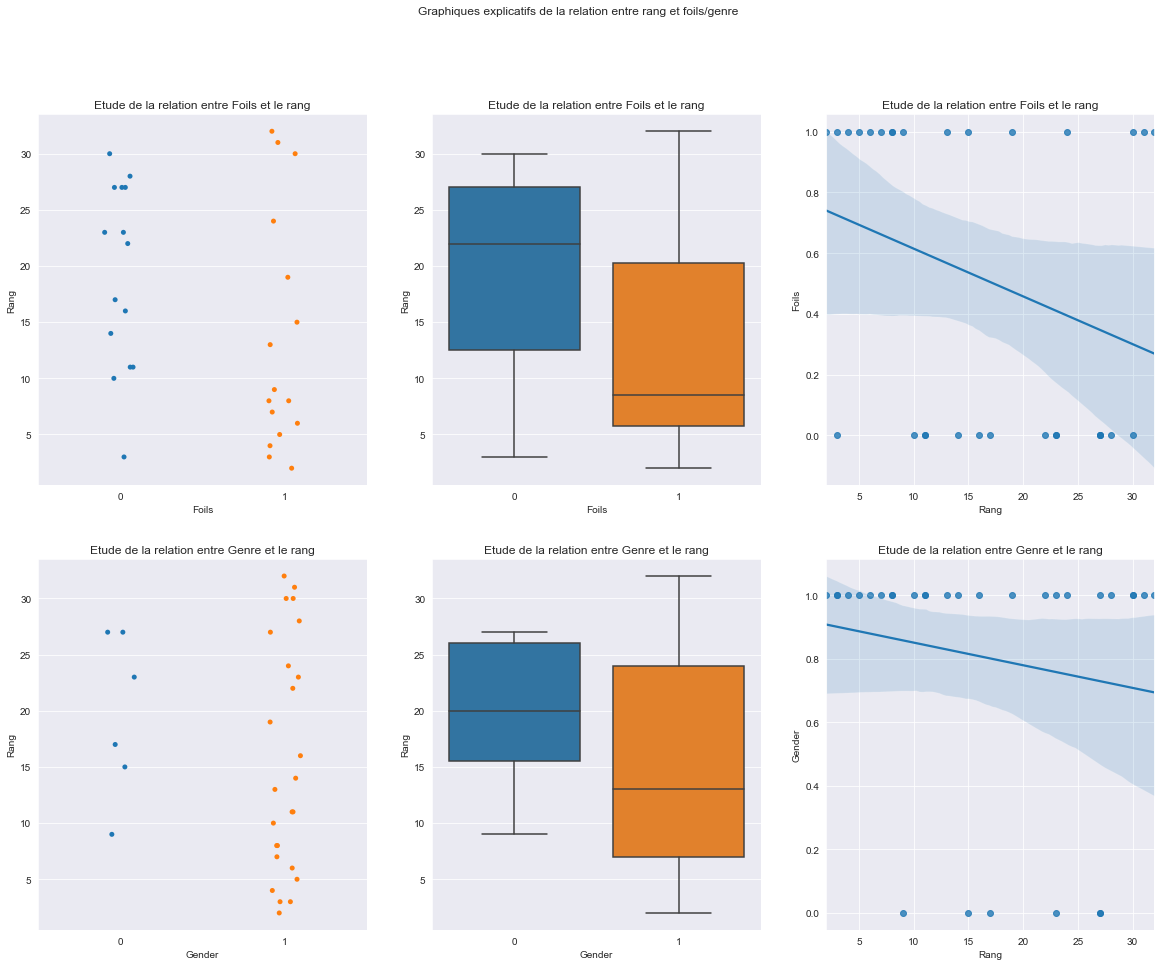

In [22]:
fig = plt.figure(figsize=(20, 15))
fig.suptitle('Graphiques explicatifs de la relation entre rang et foils/genre')
plt.subplot(231)
sns.stripplot(data=final_tab, x='Foils', y='Rang');
plt.title("Etude de la relation entre Foils et le rang");
plt.subplot(232)
sns.boxplot(y="Rang", x="Foils", data=final_tab);
plt.title("Etude de la relation entre Foils et le rang");
plt.subplot(233)
print("Nombre de foils (1 = présent / 0 = absent)\n"+ final_tab["Foils"].value_counts().to_string())
sns.regplot(y="Foils", x="Rang", data=final_tab);
plt.title("Etude de la relation entre Foils et le rang");
########################################################
plt.subplot(234)
sns.stripplot(data=final_tab, x='Gender', y='Rang');
plt.title("Etude de la relation entre Genre et le rang");
plt.subplot(235)
sns.boxplot(y="Rang", x="Gender", data=final_tab);
plt.title("Etude de la relation entre Genre et le rang");
plt.subplot(236)
print("Nombre de M/F (1 = M / 0 = F)\n"+final_tab["Gender"].value_counts().to_string())
sns.regplot(y="Gender", x="Rang", data=final_tab);
plt.title("Etude de la relation entre Genre et le rang");


Foils / Rang : déjà il y a quasi équité entre la présence ou non de foils parmi les participants mais clairement la majorité des skippers équipés arrivent dans les premières places même en valeur médiane

Gender / Rang : là il y a une forte disparité puisque nous avons seulement 6 participantes, l'une est très souvent dans les 10 premières places comparée à ces concurrentes souvent en dessous des 15 premières. Ainsi il y a une sensibilité mais on ne peut pas affirmer la corrélation entre genre et rang, il nous faudrait plus de participantes. 

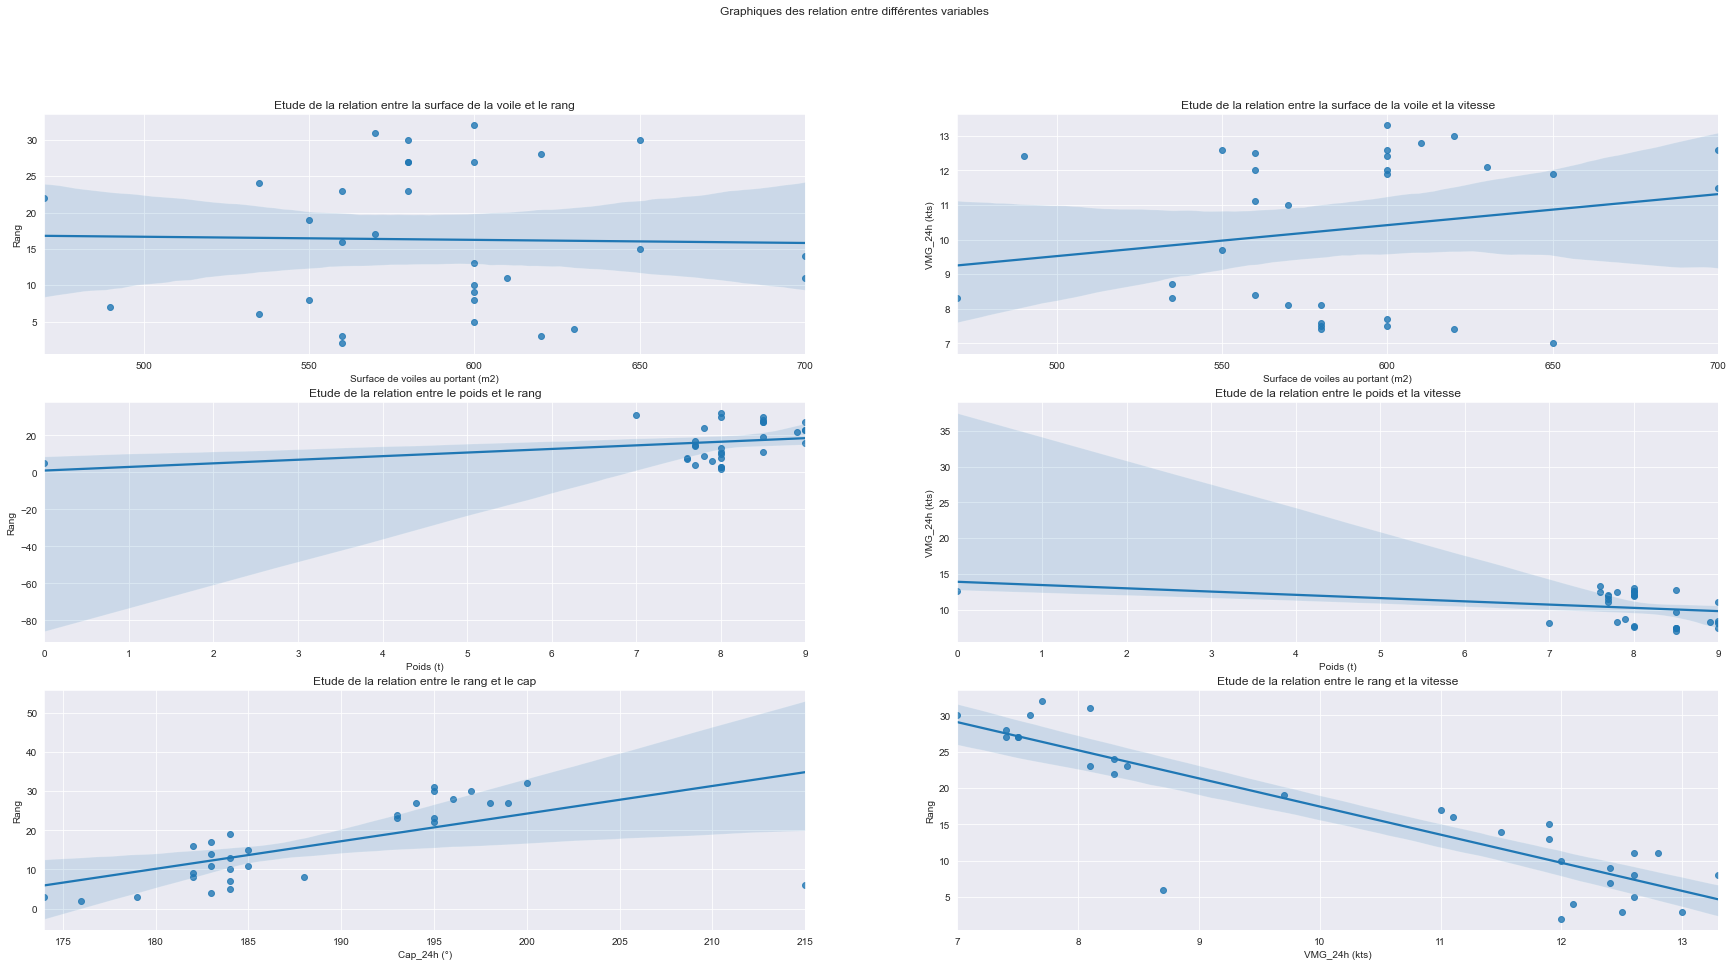

In [23]:
fig = plt.figure(figsize=(30, 15))
fig.suptitle('Graphiques des relation entre différentes variables');
###
plt.subplot(321)
sns.regplot(y="Rang", x="Surface de voiles au portant (m2)", data=final_tab);
plt.title("Etude de la relation entre la surface de la voile et le rang");
plt.subplot(322)
sns.regplot(y="VMG_24h (kts)", x="Surface de voiles au portant (m2)", data=final_tab);
plt.title("Etude de la relation entre la surface de la voile et la vitesse");
###
plt.subplot(323)
sns.regplot(y="Rang", x="Poids (t)", data=final_tab);
plt.title("Etude de la relation entre le poids et le rang");
plt.subplot(324)
sns.regplot(y="VMG_24h (kts)", x="Poids (t)", data=final_tab);
plt.title("Etude de la relation entre le poids et la vitesse");
###
plt.subplot(325)
sns.regplot(y="Rang", x="Cap_24h (°)", data=final_tab);
plt.title("Etude de la relation entre le rang et le cap");
plt.subplot(326)
sns.regplot(y="Rang", x="VMG_24h (kts)", data=final_tab);
plt.title("Etude de la relation entre le rang et la vitesse");

Maintenant étudions d'autres relations de variable :

 - le poids semble peu influencer malgré une donnée manquante (mise à 0)

 - surface de la voile semble influencée la VMG (ce qui paraitrait assez logique puisque plus la surface serait importante plus il y aura de surface contact avec les vents et donc plus de force développée pour pousser le bateau) 

 - pour finir la VMG semble elle aussi influencée le rang (ce qui est à nouveau logique puisque dans une course plus on va vite plus on se rapproche de l'arrivée CQFD !) et comme le cap influence la direction du vent sur la voile donc la vitesse.


### Random Forest : feature importances

Passons maintenant à un algorithme ensembliste : le Random Forest, je vais ici l'utliser afin de comprendre les features qui amènent le plus souvent à être dans les premières places.
Pour celà je vais déjà conserver seulement la VMG last (la plus récente enregistrée) car la VMG est une autre formulation de la vitesse qui fait appel à la notion de distance ainsi que le cap (dans le cas de la VMG).
De plus la DTL et DTF sont des distances par rapport à des référentiels (point d'arrivée et premier au classement) donc ce ne sont pas des features sur lesquelles un participant peut jouer.

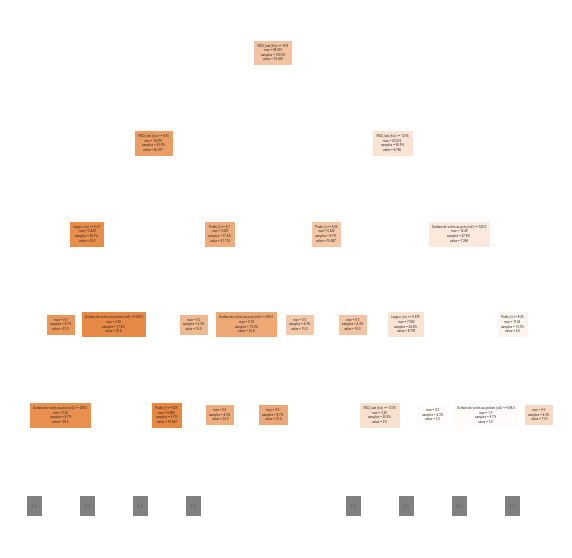

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from dtreeviz.trees import dtreeviz # will be used for tree visualization
from sklearn import tree

rf_tab = final_tab.drop(['DTL (nm)', 'DTF (nm)', 'Distance_24h (nm)', 'Vitesse_24h (kts)', 'VMG_24h (kts)', 'Cap_24h (°)', 'Distance_30m (nm)', 'Vitesse_30m (kts)', 'VMG_30m (kts)', 'Cap_30m (°)', 'Distance_last (nm)', 'Vitesse_last (kts)', 'Cap_last (°)'], axis=1)

target = rf_tab.pop('Rang')
variables = rf_tab

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                        max_features='auto', max_samples=None, min_samples_leaf=2,
                        min_samples_split=3, n_estimators=10, n_jobs=None,
                        oob_score=False, random_state=None, verbose=0)
rf = RandomForestRegressor(n_estimators=10)
rf.fit(variables.values, target.values)

# Plot each forest 
"""
for i in range (len(rf.estimators_)):
    plt.figure(figsize=(10,10))
    tree.plot_tree(rf.estimators_[i], filled=True)
"""

# Plot best forest
plt.figure(figsize=(10,10))
_ = tree.plot_tree(rf.estimators_[0], feature_names=variables.columns, filled=True, proportion=True, max_depth=4, fontsize=3)

J'affiche le résultat, on peut ainsi comprendre que la VMG caractérise le plus le rang et qu'il faut être supérieur à 12.5 environ pour être dans les 5ers. De plus la surface au portant est aussi importante certainement pour augmenter la force vélique (d'après l'estimateur plus la surface serait importante > 615 plus on serait haut dans les classements). Enfin le poids influence aussi légèrement. On peut donc analyser ces résultats pour construire le bateau le plus performant (on a vu déjà une surface > à 615, une largeur < 5.75  etc...)

Ici l'algorithme prend peu en compte les foils dû au fait que les variables ne prennent que 2 valeurs 0/1 absent/présent mais d'après nos analyses précédents, on sait que sa présence influencerait aussi le classement.

                                   Importance
Variable                                     
VMG_last (kts)                       0.904928
Foils                                0.024238
Surface de voiles au portant (m2)    0.022826
Poids (t)                            0.016648
Largeur (m)                          0.016471
Surface de voiles au près (m2)       0.014261
Gender                               0.000629


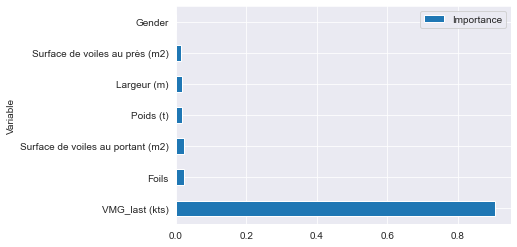

In [25]:
impVarFirst={"Variable":rf_tab.columns,"Importance":rf.feature_importances_}
df_feature_importances = pd.DataFrame(impVarFirst).set_index("Variable").sort_values(by="Importance",ascending=False)
print(df_feature_importances)
df_feature_importances.plot(kind='barh');

# Troisième Partie : Visualisation de la course 

### Course du  premier et dernier skipper

Maintenant je regroupe dans un nouveau dataframe (df_map) les skippers ainsi que leur latitude/longitude (coordonnées GPS)
Puis je créée une fonction get_map_skipper qui prend en paramètres le dataframe, le nom du meilleur et pire skipper que l'on veut voir. De plus j'ajoute sur la map la fonctionnalité de velocity propre à ipyleaflet. Et pour m'amuser un peu je vais afficher les 2 skippers avec des icônes de bateaux différentes plutôt que d'afficher une ligne (Polyline)pour 

In [26]:
df_map = df_cleaned[["Skipper", "Lat", "Long"]]
df_map

,Skipper,Lat,Long
33,Louis Burton,46.412778,-1.846667
34,Boris Herrmann,46.409444,-1.839444
35,Jérémie Beyou,46.425278,-1.844167
36,Thomas Ruyant,46.419722,-1.835556
37,Maxime Sorel,46.416389,-1.832222
...,...,...,...
4482,Miranda Merron,-22.475556,-33.843611
4483,Ari Huusela,-18.915556,-33.994167
4484,Kojiro Shiraishi,-17.727500,-33.106111
4485,Sébastien Destremau,-17.235278,-33.039444


In [27]:
# https://ipyleaflet.readthedocs.io/en/latest/api_reference/velocity.html#
#Get velocity wind map
from ipyleaflet import Map, TileLayer, basemaps, Map, Icon, Marker, LayerGroup, basemap_to_tiles, LegendControl
from ipyleaflet.velocity import Velocity
import xarray as xr
import os

def get_map_skipper(df_map, best_skipper, baddest_skipper):

    # Initialize map
    center = [0, 0]
    zoom = 1
    m = Map(center=center, zoom=zoom, interpolation='nearest', basemap=basemaps.Esri.WorldImagery)

    if not os.path.exists('wind-global.nc'):
        url = 'https://github.com/benbovy/xvelmap/raw/master/notebooks/wind-global.nc'
        r = requests.get(url)
        wind_data = r.content
        with open('wind-global.nc', 'wb') as f:
            f.write(wind_data)

    ds = xr.open_dataset('wind-global.nc')
    display_options = {
        'velocityType': 'Global Wind',
        'displayPosition': 'bottomleft',
        'displayEmptyString': 'No wind data'
    }
    wind = Velocity(data=ds,
                    zonal_speed='u_wind',
                    meridional_speed='v_wind',
                    latitude_dimension='lat',
                    longitude_dimension='lon',
                    velocity_scale=0.01,
                    max_velocity=20,
                    display_options=display_options)


    # add markers for cities with population >= 3M
    cmap = mpl.cm.ocean
    layers = []

    df_map_best = df_map.loc[df_map['Skipper'] == best_skipper]
    df_map_baddest = df_map.loc[df_map['Skipper'] == baddest_skipper]
    
    icon_best = Icon(icon_url='https://www.icone-png.com/png/11/10508.png', icon_size=[15, 15])
    icon_baddest = Icon(icon_url='https://www.icone-png.com/png/46/46176.png', icon_size=[15, 15])

    for i, row1 in df_map_best.iterrows():
        marker = Marker(location=[row1['Lat'], row1['Long']],
                        draggable=False,
                        icon=icon_best,
                        title=row1['Skipper'])
        layers.append(marker)
    
    for j, row2 in df_map_baddest.iterrows():
        marker = Marker(location=[row2['Lat'], row2['Long']],
                        draggable=False,
                        icon=icon_baddest,
                        title=row2['Skipper'])
        layers.append(marker)


    layer_group = LayerGroup(layers=layers)
    legend = LegendControl({best_skipper:  "#FFFF00", baddest_skipper: "#A52A2A"}, name="Skippers", position="bottomright")

    m.add_control(legend)
    m.add_layer(wind)
    m.add_layer(layer_group)

    m
    m.save('my_map.html', title='My Map')


In [28]:
best_skipper = final_tab["Rang"].idxmin()
baddest_skipper = final_tab["Rang"].idxmax()

get_map_skipper(df_map, best_skipper, baddest_skipper)

### Pour conclure, je dirais que ce projet représente bien la réalité et difficulté des projets d'analyse de donnée. J'ai passé 60/70% du temps à récupérer la donnée, la nettoyer, la formater pour être facilement utilisable par des algos. Ainsi toutes les méthodes et tips que vous nous avez fournis sont plus qu'utiles. De plus ce projet est une mise en pratique intéressante et originale même pour quelqu'un qui ne s'y connait pas tellement en voilure ...
Merci pour vos cours et bonne continuation à vous.